# Programming Deep Networks Efficiently

In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras import utils
from matplotlib import pyplot as plt
import numpy as np

## 1. Why does my training take weeks? - Diagnosing Performance

### Where is the bottleneck?

-   Parallel processors (GPUs or TPUs) speed up training significantly
-   Providing data to GPU is an ETL (extract, transform, load) process
    -   extract: read from memory or from file
    -   transform: preprocess data
    -   load: transfer data to GPU memory
-   Performance bottlenecks can hide in each step (or in the GPU
    computation)

Useful tools:

-   GPU monitor (usually `nvidia-smi`)
    -   is GPU memory used well (not full, not empty)?
    -   is the GPU working at full load?
    -   per-device view (`dmon`) and per-process view (`pmon`)
-   CPU monitor (e.g., `top / htop`)
    -   is the CPU working at full load?
    -   how many threads are active? Is parallelization possible?
-   Disk I/O monitor (e.g., `iostat`)
    -   does data loading take too long?

### Profiling with TensorBoard

-   Tensorboard can display profiling information across devices.
-   Automatically included when using `tf.keras.callbacks.TensorBoard()`
    callback

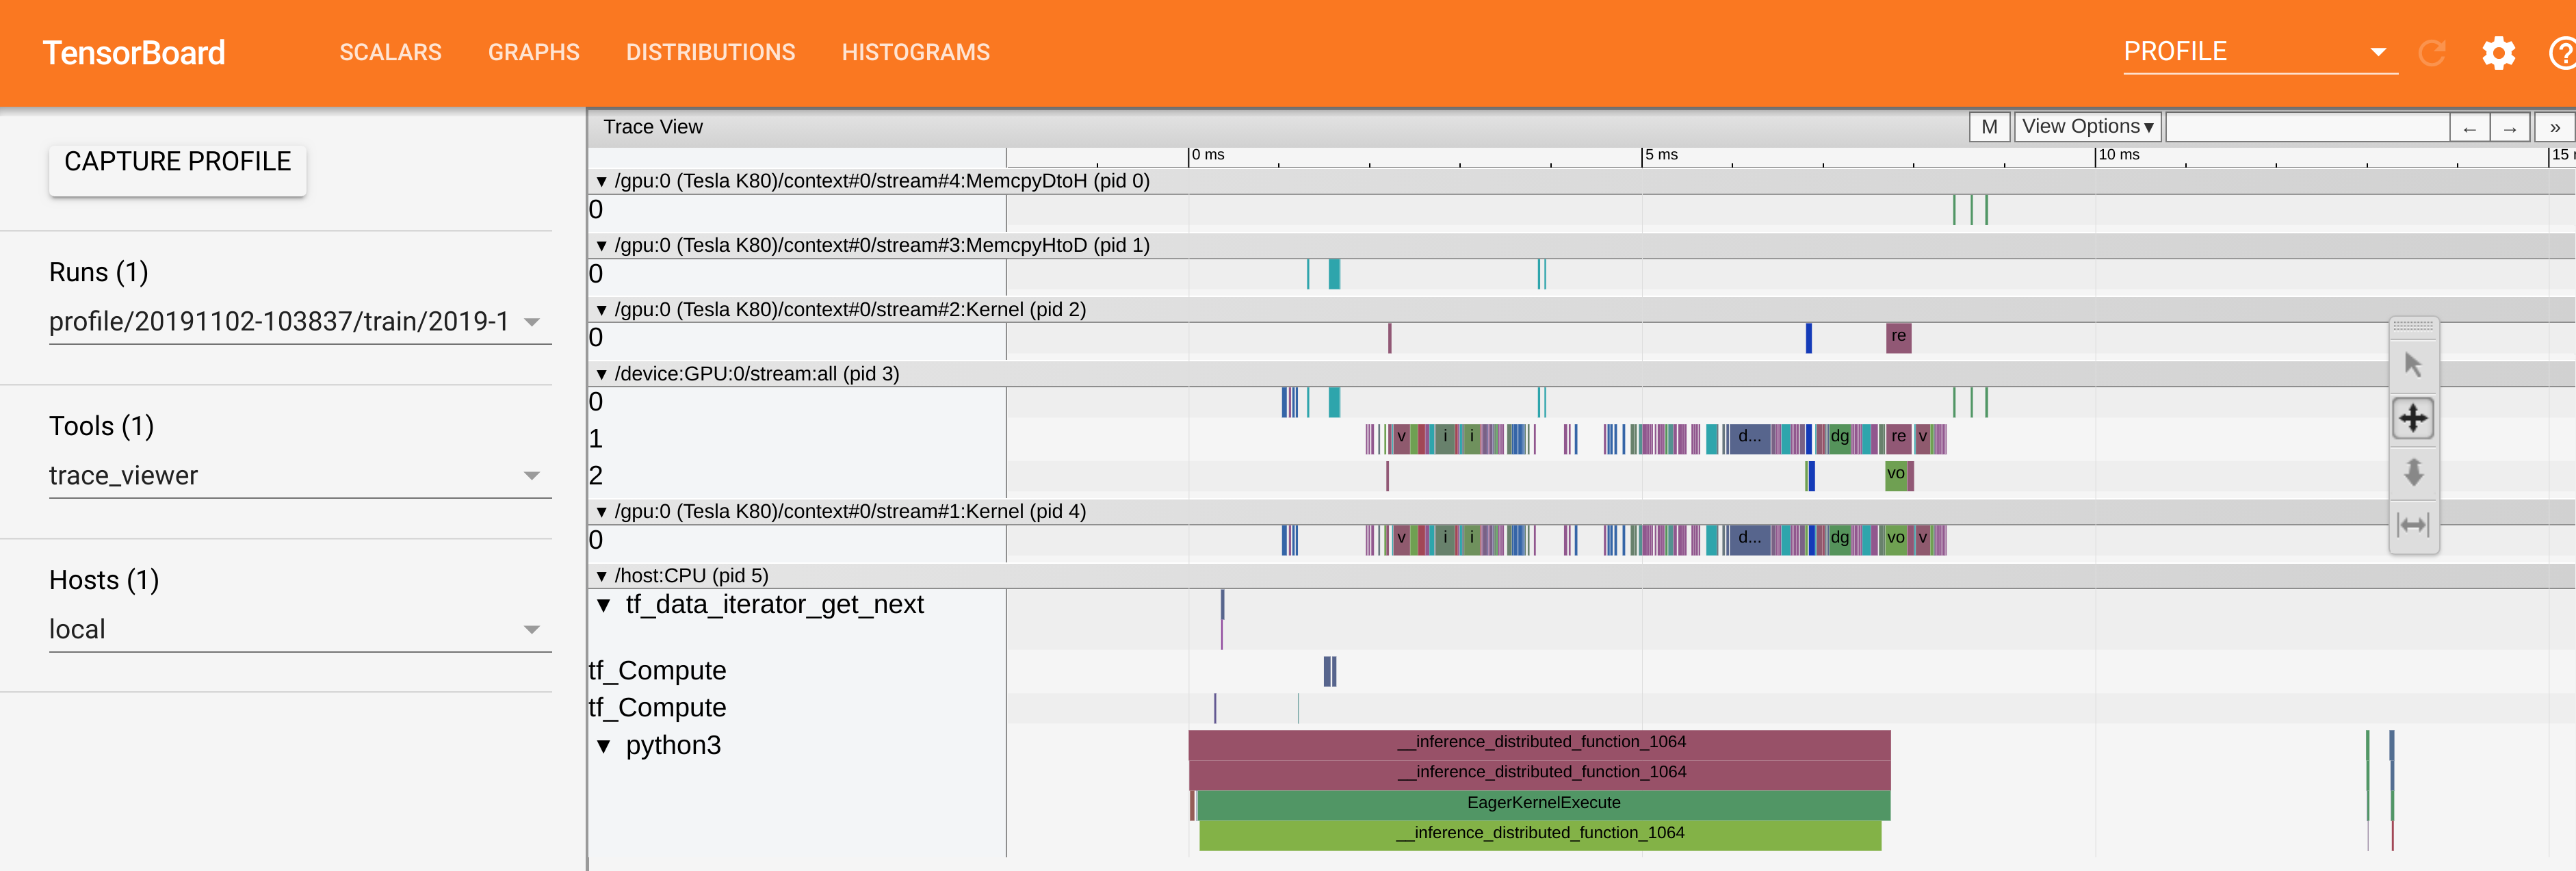

-   Look out for long idle times on compute device.

### Exercise

-   Train a small network on a dataset of your choice.
-   Include a
    [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)
    callback.
-   Start tensorboard and point it to the directory of your log files.
-   Investigate the profiling trace.

### Hardware solutions

| Bottleneck                 | Solutions                          |
|:---------------------------|:-----------------------------------|
| GPU too slow (computation) | More / newer GPUs                  |
| GPU memory bandwidth       | Use fast PCI lane, link technology |
| CPU preprocessing          | More / newer CPUs                  |
| Disk reads                 | Use NVMe SDD                       |

### Software solutions

| Bottleneck                 | Solutions                           |
|:---------------------------|:------------------------------------|
| GPU too slow (computation) | Optimize network, distribute        |
| GPU memory bandwidth       | Tune batchsize, cache on GPU        |
| CPU preprocessing          | Parallelize preprocessing, prefetch |
| Disk reads                 | Cache data in RAM, adjust schedule  |

-   most common problem is **loading** and **preprocessing**

## 2. Loading Datasets

-   Feeding Data with feed\_dict is very slow
-   Tensorflow 2.0 introduces a new API for efficient data loading and
    processing
-   Dataset is basically a sequence, e.g. a set of images and their
    respective label
-   Datasets can process NumPy arrays (e.g. images), csv files, text
    data, and others

In [ ]:
# load the mnist dataset
from utils import mnist_imgs, mnist_lbls
labels = utils.to_categorical(mnist_lbls, 10)

# transform into dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist_imgs[i][:, :, 0], cmap=plt.cm.binary)
dataset = tf.data.Dataset.from_tensor_slices((mnist_imgs, labels))
plt.show()

-   provides four important functions: batch, repeat, shuffle, and
    prefetch
-   The simplest form of batching stacks $n$ consecutive elements of a
    dataset into a single element by using Dataset.batch().

In [ ]:
# creates data with batch size of 32 
# for 3 epochs, shuffled in 100'000 samples
# prefetched each 10'000 samples
epochs = 3
batched_dataset = dataset.batch(32).repeat(epochs).shuffle(buffer_size=100000).prefetch(buffer_size=10000)

-   `prefetch` ensures that next sample is already loaded while current
    one is processed

We can now train our model by providing the dataset:

In [ ]:
from utils import build_model
 
model = build_model()
model.fit(batched_dataset)

### Exercise

-   Train the same model as earlier, again using a tensorboard callback.
-   This time, use appropriate a dataset with prefetching.
-   Compare the resulting profiling traces.

## 3. Data Preprocessing and Augmentation

-   Mainly for Images
-   Preprocessing prepares Data for Neural Nets
    -   they like data to be in the same range
-   Augementation creates new data
    -   Better Generalization
-   Examples for Preprocessing:
    -   Centering: Subtract Mean
    -   Standarization: Divide by Standard Deviation
-   Examples for Augmentation:
    -   Rotate, Shift, Shear, Zoom
    -   Horizontal/Vertical Flip
    -   Change Brightness

Extremely Cute Example for Data Augementation:

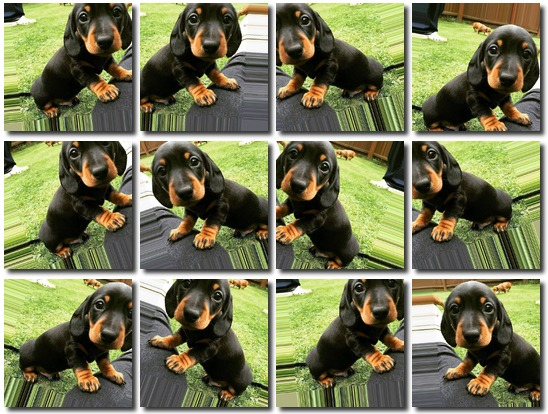 source:
https://rock-it.pl/content/images/2017/05/doggs.jpg

### ImageDataGenerator

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
num_classes = 10
epochs = 10
batch_size = 32
input_shape = (32, 32, 3)

# load data, here we look at CIFAR 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

In [ ]:
# prepare data image generator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

### Exercise

Load the cifar10 dataset, build a CNN model and train it using a
ImageDataGenerator as described earlier.

## 4. Lazy Loading

-   Large amount of data often can’t be loaded all at once
-   TF 2.0 provides a way to “flow” the data from a directory
    sequentially

### Example

The data has to split in a certain way: 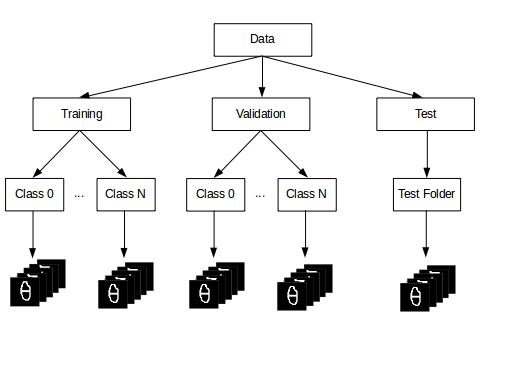 And we can use the flow from
directory method in the following way:

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)